# IMDB 무비 리뷰 모델의 서빙 예제

다음 노트북을 따라 한 것임
* https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%202/Examples/text_classification.ipynb

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.0


## IMDB 데이터셋 

In [2]:
splits = ['train[:60%]', 'train[-40%:]', 'test']

splits, info = tfds.load(name='imdb_reviews', with_info=True, split=splits, as_supervised=True)

train_data, validation_data, test_data = splits

In [3]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))

print('\u2022 {:,} movie reviews for training'.format(num_train_examples))
print('\u2022 {:,} movie reviews for testing'.format(num_test_examples))

The Dataset has a total of:
• 2 classes
• 25,000 movie reviews for training
• 25,000 movie reviews for testing


In [4]:
class_names = ['negative', 'positive']

In [5]:
for review, label in train_data.take(1):
    review = review.numpy()
    label = label.numpy()
    
    print('\nMovie Review:\n\n', review)
    print('\nLabel:', class_names[label])    


Movie Review:

 b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Label: negative


## Load Word Embeddings

* use of tensorflow hub's word embedding
  * google/tf2-preview/gnews-swivel-20dim/1
* trainable = true for fine-tuning

In [6]:
MODULE = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'
hub_layer = hub.KerasLayer(MODULE, input_shape=[], dtype=tf.string, trainable=True)

## Build pipeline

In [7]:
batch_size = 512

train_batches = train_data.shuffle(num_train_examples//4).batch(batch_size).prefetch(1)
validation_batches = validation_data.batch(batch_size).prefetch(1)
test_batches = test_data.batch(batch_size)

## Build model

In [11]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


##  Train model

Epoch 1/20
30/30 [==============================] - 1s 32ms/step - loss: 0.8847 - accuracy: 0.4793 - val_loss: 0.6945 - val_accuracy: 0.5510
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.6353 - accuracy: 0.6919 - val_loss: 0.5967 - val_accuracy: 0.7494
Epoch 3/20
30/30 [==============================] - 1s 28ms/step - loss: 0.5456 - accuracy: 0.8013 - val_loss: 0.5276 - val_accuracy: 0.7910
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 0.4526 - accuracy: 0.8451 - val_loss: 0.4339 - val_accuracy: 0.8284
Epoch 5/20
30/30 [==============================] - 1s 29ms/step - loss: 0.3543 - accuracy: 0.8843 - val_loss: 0.3793 - val_accuracy: 0.8529
Epoch 6/20
30/30 [==============================] - 1s 27ms/step - loss: 0.3000 - accuracy: 0.9045 - val_loss: 0.3478 - val_accuracy: 0.8598
Epoch 7/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2625 - accuracy: 0.9173 - val_loss: 0.3275 - val_accuracy: 0.8655
Epoch 8/20
30

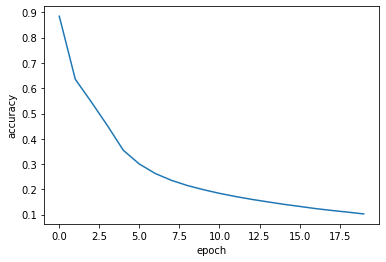

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches)

# visualize training
plt.plot(history.history['loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

## evaluate model

In [13]:
eval_results = model.evaluate(test_batches, verbose=0)

for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.3}'.format(value))

loss: 0.336
accuracy: 0.865


## Save model for serving

In [16]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=None,
    save_format=None,  # default to tf
    signatures=None,
    options=None
)

print('\nSaved model: ')
!ls -l {export_path}

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model: 
total 116
drwxr-xr-x 2 hoondori hoondori   4096  4월  6 21:53 assets
-rw-rw-r-- 1 hoondori hoondori 109155  4월  6 21:53 saved_model.pb
drwxr-xr-x 2 hoondori hoondori   4096  4월  6 21:53 variables


## Examine saved model

In [17]:
!saved_model_cli show --dir {export_path} --all

2021-04-06 21:53:47.475157: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.1/lib64:/usr/local/cuda/extras/CUPTI/lib64
2021-04-06 21:53:47.475175: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['keras_layer_input']

## Serve model with Tensorflow Serving

In [18]:
os.environ['MODEL_DIR'] = MODEL_DIR

In [19]:
%%bash --bg
nohup tensorflow_model_server \
    --rest_api_port=8501 \
    --model_name=imdb_reviews \
    --model_base_path="${MODEL_DIR}" > server.log 2>&1

In [20]:
!tail server.log

To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-06 21:54:46.797509: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-04-06 21:54:46.816110: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz
2021-04-06 21:54:46.840211: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/1
2021-04-06 21:54:46.850052: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 106569 microseconds.
2021-04-06 21:54:46.850461: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-04-06 21:54:46.850723: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: imdb_review

## Make request to serving 

In [37]:
test_reviews = []
test_labels = []
for test_review, test_label in test_data.take(3):
    review = test_review.numpy().decode("utf-8") 
    label = test_label.numpy()
    test_reviews.append(review)
    test_labels.append(label)
    
    print('\nTest Review:\n\n', review)
    print('\nLabel:', class_names[label])
    


Test Review:

 There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.

Label: positive

Test Review:

 A blackly c

In [34]:
import json
data = json.dumps({'signature_name':'serving_default', 'instances': test_reviews})

In [50]:
import requests


headers = {'content-type': 'application/json' }
json_resp = requests.post('http://localhost:8501/v1/models/imdb_reviews:predict',
                         data=data, headers=headers)
predictions = json.loads(json_resp.text)['predictions']

def prediction_to_label(predictions):
     return [1 if pp[0] > 0.5 else 0 for pp in predictions]
    
predicted_labels = prediction_to_label(predictions)

In [51]:
for i in range(len(test_reviews)):
    print('expected: {}, predicted: {}'.format(
        class_names[test_labels[i]], class_names[predicted_labels[i]]))


expected: positive, predicted: negative
expected: positive, predicted: positive
expected: negative, predicted: negative
